In [1]:
import torch
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import math

from collections.abc import Callable

In [2]:
def random_SSM(N : int) -> (torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor):
    A = torch.autograd.Variable(torch.rand(size=(N,N)), requires_grad = True)
    B = torch.autograd.Variable(torch.rand(size=(N,1)), requires_grad = True)
    C = torch.autograd.Variable(torch.rand(size=(1,N)), requires_grad = True)
    D = torch.autograd.Variable(torch.rand(size=(1,1)), requires_grad = True)
    return A, B, C, D

In [3]:
A, B, C, D = random_SSM(10)


In [4]:
D = torch.zeros((1,1))

In [5]:
delta = torch.tensor(0.01)

In [6]:
def discretize(
    A : torch.Tensor, B : torch.Tensor, C : torch.Tensor, D : torch.Tensor, delta : torch.Tensor
) -> (torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor):
    """Discretizes SSM using bilinear model

    parameters:
        A: (NxN) transition matrix in latent
        B: (Nx1) projection matrix to latent
        C: (1xN) projection matrix from latent to output
        D: (1x1) skip connection from input to output
        delta: time step, ensure sufficient smallness
    """
    Cbar = C
    Dbar = D
    N = A.shape[0]
    Bl = torch.linalg.inv(torch.eye(N) - delta / 2 * A)
    Abar = Bl@(torch.eye(N) + delta/2 * A)
    Bbar = Bl@(delta*B)
    return Abar, Bbar, Cbar, Dbar

In [7]:
Abar, Bbar, Cbar, Dbar = discretize(A, B, C, D, delta)

In [8]:
T = 100
num_steps = int(T/delta)

u = torch.cos(torch.arange(num_steps))

In [9]:
def scan_SSM(
    Ab : torch.Tensor, Bb : torch.Tensor, Cb : torch.Tensor, Db : torch.Tensor,  u : torch.Tensor, x0 : torch.Tensor
) -> torch.Tensor:
    """
    computes steps of the SSM going forward.

    parameters:
        Ab : (NxN) transition matrix in discrete space of latent to latent
        Bb : (Nx1) projcetion matrix from input to latent space
        Cb : (1xN) projection matrix from latent to output
        Db : (1x1) skip connection input to output
        u  : (L,)  trajectory we are trying to track
        x0 : (Nx1) initial condition of latent
    """
    x0 = torch.zeros((10,1))
    x = torch.zeros((Ab.shape[0], len(u[:100])))
    y = torch.zeros_like(u[:100])
    for i in range(u[:100].shape[0]):
        x[:,i] = (Ab@x0 + Bb*u[i]).squeeze()
        y[i] = (Cb@x[:,i]).squeeze()
        x0 = x[:,i].unsqueeze(-1)
    return x, y

In [10]:
def K_conv(Ab : torch.Tensor, Bb : torch.Tensor, Cb : torch.Tensor, L : int) -> torch.Tensor:
    """
    computes convolution window given L time steps using equation K_t = Cb @ (Ab^t) @ Bb. 
    Needs to be flipped for correct causal convolution, but can be used as is in fft mode

    parameters:
        Ab : transition matrix
        Bb : projection matrix from input to latent
        Cb : projection matrix from latent to input
        Db : skip connection
        L  : length over which we want convolutional window
    """
    return torch.stack([(Cb @ torch.matrix_power(Ab, l) @ Bb).squeeze() for l in range(L)])

In [11]:
def causal_conv(u : torch.Tensor, K : torch.Tensor, notfft : bool = False) -> torch.Tensor:
    """
    computes 1-d causal convolution either using standard method or fft transform.

    parameters:
        u : trajectory to convolve
        K : convolutional filter
        notfft: boolean, for whether or not we use fft mode or not.
    """
    assert len(u.shape)==1
    assert K.shape==u.shape
    
    L = u.shape[0]
    powers_of_2 = 2**int(math.ceil(math.log2(2*L)))

    if notfft:
        padded_u = torch.nn.functional.pad(u, (L-1,L-1))
        convolve = torch.zeros_like(u)
        for i in range(L):
            convolve[i] = torch.sum(padded_u[i:i+L]*K.flip(dims=[0]))
        return convolve
    else:

        K_pad = torch.nn.functional.pad(K, (0, L))
        u_pad = torch.nn.functional.pad(u, (0, L))
        
        K_f, u_f = torch.fft.rfft(K_pad, n = powers_of_2), torch.fft.rfft(u_pad, n = powers_of_2)
        return torch.fft.irfft(K_f * u_f, n = powers_of_2)[:L]

In [12]:
K = K_conv(Abar, Bbar, Cbar, 100)

In [13]:
conv_fft = causal_conv(u[:100], K)
conv_notfft = causal_conv(u[:100],K , notfft=True)

In [14]:
x, y = scan_SSM(Abar, Bbar, Cbar, Dbar, u[:100], torch.zeros((10,1)))

In [15]:
print((abs(conv_fft - conv_notfft)<1e-5).all())
print((abs(conv_fft - y)<1e-5).all())

tensor(True)
tensor(True)


In [16]:
def log_step_initializer(dt_min = 0.001, dt_max = 0.1):
    """
    initial guess for dt, from random number generator. to be learned.

    parameters:
        dt_min
        dt_max
    """
    return torch.autograd.Variable(torch.rand(1) * (torch.log(dt_max) - torch.log(dt_min)) + torch.log(dt_min), requires_grad = True)

In [17]:
class SSMLayer(torch.nn.Module):
    """
    Simple layer that does SSMing. Assumes single input, single output. 
    Could be made multi-dimensional either by stacking and decorrelating,
    or by playing with the code to allow for multi input, multioutput. Should be relatively easy, 
    but need to carefully think a little about convolution of multi dim inputs.
    """
    def __init__(
        self,
        latent_dim,
        L_max,
        dt_min = 0.001,
        dt_max = 0.1,
    ):
        super().__init__()
        self.latent_dim = latent_dim
        self.A, self.B, self.C, self.D = self.random_SSM(latent_dim)
        self.Abar, self.Bbar, self.Cbar, self.Dbar = self.discretize(self.A, self.B, self.C, self.D, self.dt)
        self.dt = self.log_step_initializer(dt_min, dt_max)

    def random_SSM(
        self, 
        N : int
    ) -> (torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor):
        """
        initializing SSM parameters given latent dim
        
        parameters:
            N : size of latent dimension
        """
        A = torch.autograd.Variable(torch.rand(size=(N,N)), requires_grad = True)
        B = torch.autograd.Variable(torch.rand(size=(N,1)), requires_grad = True)
        C = torch.autograd.Variable(torch.rand(size=(1,N)), requires_grad = True)
        D = torch.autograd.Variable(torch.rand(size=(1,1)), requires_grad = True)
        return A, B, C, D

    def log_step_initializer(self, dt_min = 0.001, dt_max = 0.1):
        """
        initial guess for dt, from random number generator. to be learned.
    
        parameters:
            dt_min
            dt_max
        """
        return torch.autograd.Variable(torch.rand(1) * (torch.log(dt_max) - torch.log(dt_min)) + torch.log(dt_min), requires_grad = True)

    def discretize(
        self, A : torch.Tensor, B : torch.Tensor, C : torch.Tensor, D : torch.Tensor, delta : torch.Tensor
    ) -> (torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor):
        """Discretizes SSM using bilinear model
    
        parameters:
            A: (NxN) transition matrix in latent
            B: (Nx1) projection matrix to latent
            C: (1xN) projection matrix from latent to output
            D: (1x1) skip connection from input to output
            delta: time step, ensure sufficient smallness
        """
        Cbar = C
        Dbar = D
        N = A.shape[0]
        Bl = torch.linalg.inv(torch.eye(N) - delta / 2 * A)
        Abar = Bl@(torch.eye(N) + delta/2 * A)
        Bbar = Bl@(delta*B)
        return Abar, Bbar, Cbar, Dbar

    def scan_SSM(
        self, Ab : torch.Tensor, Bb : torch.Tensor, Cb : torch.Tensor, Db : torch.Tensor,  u : torch.Tensor, x0 : torch.Tensor
    ) -> torch.Tensor:
        """
        computes steps of the SSM going forward.
    
        parameters:
            Ab : (NxN) transition matrix in discrete space of latent to latent
            Bb : (Nx1) projcetion matrix from input to latent space
            Cb : (1xN) projection matrix from latent to output
            Db : (1x1) skip connection input to output
            u  : (L,)  trajectory we are trying to track
            x0 : (Nx1) initial condition of latent
        """
        x0 = torch.zeros((10,1))
        x = torch.zeros((Ab.shape[0], len(u[:100])))
        y = torch.zeros_like(u[:100])
        for i in range(u[:100].shape[0]):
            x[:,i] = (Ab@x0 + Bb*u[i]).squeeze()
            y[i] = (Cb@x[:,i]).squeeze()
            x0 = x[:,i].unsqueeze(-1)
        return x, y
        
    def K_conv(self, Ab : torch.Tensor, Bb : torch.Tensor, Cb : torch.Tensor, L : int) -> torch.Tensor:
        """
        computes convolution window given L time steps using equation K_t = Cb @ (Ab^t) @ Bb. 
        Needs to be flipped for correct causal convolution, but can be used as is in fft mode
    
        parameters:
            Ab : transition matrix
            Bb : projection matrix from input to latent
            Cb : projection matrix from latent to input
            Db : skip connection
            L  : length over which we want convolutional window
        """
        return torch.stack([(Cb @ torch.matrix_power(Ab, l) @ Bb).squeeze() for l in range(L)])

    def causal_conv(u : torch.Tensor, K : torch.Tensor, notfft : bool = False) -> torch.Tensor:
        """
        computes 1-d causal convolution either using standard method or fft transform.
    
        parameters:
            u : trajectory to convolve
            K : convolutional filter
            notfft: boolean, for whether or not we use fft mode or not.
        """
        assert K.shape==u.shape
        
        L = u.shape[0]
        powers_of_2 = 2**int(math.ceil(math.log2(2*L)))
    
        if notfft:
            padded_u = torch.nn.functional.pad(u, (L-1,L-1))
            convolve = torch.zeros_like(u)
            for i in range(L):
                convolve[i] = torch.sum(padded_u[i:i+L]*K.flip(dims=[0]))
            return convolve
        else:
    
            K_pad = torch.nn.functional.pad(K, (0, L))
            u_pad = torch.nn.functional.pad(u, (0, L))
            
            K_f, u_f = torch.fft.rfft(K_pad, n = powers_of_2), torch.fft.rfft(u_pad, n = powers_of_2)
            return torch.fft.irfft(K_f * u_f, n = powers_of_2)[:L]

    def forward(
        self,
        u : torch.Tensor,
        x0 : torch.Tensor = torch.zeros((1,1)),
        mode : bool | str = False
    ) -> torch.Tensor:
        """
        forward pass of model

        Parameters:
            u  : input time series
            x0 : initial condition, only used in recurrent mode
            mode: recurrent mode ("recurrent"), or convolution mode (True : direct convolution, False : fourier transform)
        """
        if mode == "recurrent":
            return self.scan_SSM(self.Abar, self.Bbar, self.Cbar, u, x0)[1]
        else:
            K = self.K_conv(self.Abar, self.Bbar, self.Cbar, u.shape[0])
            return self.causal_conv(u, K, mode)

In [18]:
def make_HiPPO(N : int) -> torch.Tensor:
    """
    creates HiPPO matrix for legendre polynomials up to order N
    parameters:
        N: int
    """
    P = torch.sqrt(1+2*torch.arange(N))
    A = P.unsqueeze(1) * P.unsqueeze(0)
    A = torch.tril(A) - torch.diag(torch.arange(N))
    return A

In [19]:
def K_gen_inverse(
    Abar : torch.Tensor, Bbar : torch.Tensor, Cbar : torch.Tensor, L : int
) -> torch.Tensor:
    """
    creates generating function for convolutional window, to be evaluated at roots of unity
    parameters:
        Abar : discretized A matrix
        Bbar : discretized B matrix
        Cbar : discretized C matrix
        L    : length of convolutional window
    """
    Abar = Abar.to(torch.complex64)
    Bbar = Bbar.to(torch.complex64)
    Cbar = Cbar.to(torch.complex64)
    
    I = torch.eye(Abar.shape[0]).to(torch.complex64)
    Al = torch.matrix_power(Abar, L)
    Ctilde = Cbar @ (I - (Al))
    return lambda z: (torch.conj(Ctilde)@(torch.linalg.inv(I-Abar * z))@Bbar).squeeze()

In [20]:
blah = K_gen_inverse(Abar, Bbar, Cbar, 10)

In [21]:
blah(10)

tensor(0.0017+0.j, grad_fn=<SqueezeBackward0>)

In [22]:
def conv_from_gen(gen : Callable, L : int):
    """
    returns convolution from generating function by evaluating at roots of unity

    parameters:
        gen : generating function
        L   : int
    """
    omega_L = torch.exp(-2j * torch.pi * torch.arange(L)/L)
    atRoots = torch.tensor([gen(omega) for omega in omega_L])
    
    return torch.fft.irfft(atRoots, L).squeeze()
    

In [23]:
blah = K_gen_inverse(Abar, Bbar, Cbar, 100)

In [24]:
omega_L = torch.exp(-2j * torch.pi * torch.arange(100)/100)
atRoots = torch.tensor([blah(omega) for omega in omega_L])

In [33]:
torch.nn.functional.pad(atRoots, (0, 100))

tensor([ 7.1253e+01+0.0000e+00j,  2.6539e+01+3.5403e+01j,
         8.2175e+00+2.5012e+01j,  3.0171e+00+1.8032e+01j,
         9.8631e-01+1.3897e+01j,  4.5121e-03+1.1241e+01j,
        -5.4048e-01+9.4047e+00j, -8.7315e-01+8.0635e+00j,
        -1.0907e+00+7.0413e+00j, -1.2406e+00+6.2358e+00j,
        -1.3482e+00+5.5841e+00j, -1.4280e+00+5.0452e+00j,
        -1.4888e+00+4.5915e+00j, -1.5361e+00+4.2037e+00j,
        -1.5737e+00+3.8678e+00j, -1.6041e+00+3.5735e+00j,
        -1.6289e+00+3.3132e+00j, -1.6494e+00+3.0808e+00j,
        -1.6667e+00+2.8716e+00j, -1.6812e+00+2.6821e+00j,
        -1.6936e+00+2.5092e+00j, -1.7043e+00+2.3506e+00j,
        -1.7135e+00+2.2043e+00j, -1.7215e+00+2.0687e+00j,
        -1.7284e+00+1.9423e+00j, -1.7346e+00+1.8241e+00j,
        -1.7400e+00+1.7131e+00j, -1.7448e+00+1.6084e+00j,
        -1.7491e+00+1.5093e+00j, -1.7529e+00+1.4153e+00j,
        -1.7562e+00+1.3257e+00j, -1.7593e+00+1.2401e+00j,
        -1.7620e+00+1.1580e+00j, -1.7644e+00+1.0792e+00j,
        -1.766

In [32]:
torch.fft.irfft(torch.nn.functional.pad(atRoots, (0, 100)), 256)

tensor([-2.5623e-01,  9.1583e-01, -9.9178e-01,  6.5709e-01, -4.8194e-02,
        -4.5761e-01,  7.3345e-01, -6.0483e-01,  2.5537e-01,  2.2062e-01,
        -5.1081e-01,  5.8729e-01, -3.4254e-01,  3.4511e-03,  3.6152e-01,
        -4.8829e-01,  4.3044e-01, -1.2678e-01, -1.6821e-01,  4.2146e-01,
        -4.1366e-01,  2.6782e-01,  5.0490e-02, -2.7539e-01,  4.1934e-01,
        -3.0423e-01,  1.1097e-01,  1.8665e-01, -3.2500e-01,  3.6912e-01,
        -1.7598e-01, -2.8123e-02,  2.7833e-01, -3.2349e-01,  2.8448e-01,
        -4.3992e-02, -1.3917e-01,  3.2440e-01, -2.7917e-01,  1.7949e-01,
         7.8086e-02, -2.1482e-01,  3.2692e-01, -2.0241e-01,  6.8204e-02,
         1.7885e-01, -2.5126e-01,  2.9134e-01, -1.0525e-01, -3.6176e-02,
         2.4994e-01, -2.4855e-01,  2.2605e-01, -4.0394e-04, -1.2231e-01,
         2.8658e-01, -2.1048e-01,  1.4161e-01,  9.9724e-02, -1.8157e-01,
         2.8787e-01, -1.4408e-01,  4.9786e-02,  1.8419e-01, -2.0870e-01,
         2.5667e-01, -5.8845e-02, -3.7649e-02,  2.4

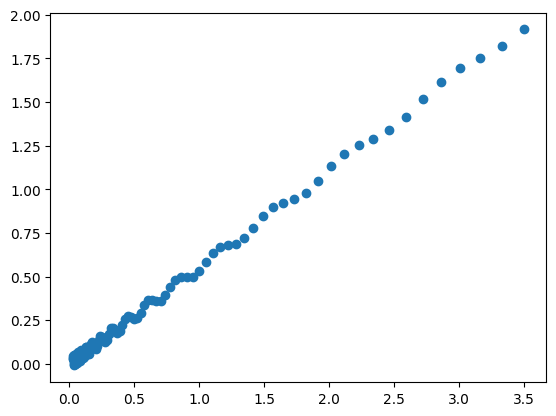

In [31]:
plt.scatter(torch.fft.irfft(atRoots, 100).detach().numpy(), conv_fft.detach().numpy())

In [26]:
conv_fft

tensor([ 2.8294e-02,  4.4835e-02,  3.5057e-02,  8.6226e-03, -9.4564e-03,
        -1.8150e-03,  2.5304e-02,  4.7789e-02,  4.5832e-02,  2.2140e-02,
        -5.5075e-04, -3.7324e-04,  2.3563e-02,  5.0360e-02,  5.6547e-02,
         3.7661e-02,  1.2354e-02,  5.2476e-03,  2.4299e-02,  5.3490e-02,
         6.7555e-02,  5.5218e-02,  2.9560e-02,  1.6001e-02,  2.8928e-02,
         5.8478e-02,  7.9609e-02,  7.5127e-02,  5.1501e-02,  3.2925e-02,
         3.9073e-02,  6.7024e-02,  9.3951e-02,  9.8116e-02,  7.8865e-02,
         5.7234e-02,  5.6620e-02,  8.1277e-02,  1.1242e-01,  1.2549e-01,
         1.1276e-01,  9.0452e-02,  8.3810e-02,  1.0393e-01,  1.3756e-01,
         1.5929e-01,  1.5495e-01,  1.3462e-01,  1.2340e-01,  1.3836e-01,
         1.7282e-01,  2.0256e-01,  2.0808e-01,  1.9253e-01,  1.7890e-01,
         1.8882e-01,  2.2276e-01,  2.5959e-01,  2.7606e-01,  2.6816e-01,
         2.5488e-01,  2.6075e-01,  2.9334e-01,  3.3631e-01,  3.6449e-01,
         3.6704e-01,  3.5746e-01,  3.6124e-01,  3.9

In [324]:
conv_notfft

tensor([ 3.2026e-02,  5.0787e-02,  3.9775e-02,  9.8950e-03, -1.0565e-02,
        -1.9347e-03,  2.8752e-02,  5.4228e-02,  5.2064e-02,  2.5292e-02,
        -3.7879e-04, -1.9867e-04,  2.6873e-02,  5.7214e-02,  6.4257e-02,
         4.2923e-02,  1.4291e-02,  6.2235e-03,  2.7752e-02,  6.0778e-02,
         7.6717e-02,  6.2783e-02,  3.3747e-02,  1.8364e-02,  3.2938e-02,
         6.6338e-02,  9.0239e-02,  8.5166e-02,  5.8408e-02,  3.7322e-02,
         4.4187e-02,  7.5728e-02,  1.0613e-01,  1.1080e-01,  8.8944e-02,
         6.4354e-02,  6.3508e-02,  9.1248e-02,  1.2634e-01,  1.4100e-01,
         1.2645e-01,  1.0101e-01,  9.3246e-02,  1.1574e-01,  1.5352e-01,
         1.7785e-01,  1.7265e-01,  1.4932e-01,  1.3624e-01,  1.5272e-01,
         1.9126e-01,  2.2445e-01,  2.3020e-01,  2.1207e-01,  1.9601e-01,
         2.0654e-01,  2.4420e-01,  2.8512e-01,  3.0295e-01,  2.9313e-01,
         2.7713e-01,  2.8270e-01,  3.1842e-01,  3.6582e-01,  3.9643e-01,
         3.9794e-01,  3.8560e-01,  3.8822e-01,  4.2

In [323]:
conv_fft

tensor([ 3.2026e-02,  5.0786e-02,  3.9775e-02,  9.8948e-03, -1.0565e-02,
        -1.9345e-03,  2.8752e-02,  5.4227e-02,  5.2064e-02,  2.5292e-02,
        -3.7849e-04, -1.9813e-04,  2.6874e-02,  5.7214e-02,  6.4257e-02,
         4.2923e-02,  1.4292e-02,  6.2244e-03,  2.7753e-02,  6.0778e-02,
         7.6717e-02,  6.2783e-02,  3.3747e-02,  1.8364e-02,  3.2938e-02,
         6.6338e-02,  9.0239e-02,  8.5166e-02,  5.8408e-02,  3.7322e-02,
         4.4187e-02,  7.5728e-02,  1.0613e-01,  1.1080e-01,  8.8944e-02,
         6.4354e-02,  6.3508e-02,  9.1249e-02,  1.2634e-01,  1.4100e-01,
         1.2645e-01,  1.0101e-01,  9.3246e-02,  1.1574e-01,  1.5352e-01,
         1.7785e-01,  1.7265e-01,  1.4932e-01,  1.3624e-01,  1.5272e-01,
         1.9126e-01,  2.2445e-01,  2.3020e-01,  2.1207e-01,  1.9601e-01,
         2.0654e-01,  2.4420e-01,  2.8512e-01,  3.0295e-01,  2.9313e-01,
         2.7713e-01,  2.8270e-01,  3.1842e-01,  3.6582e-01,  3.9643e-01,
         3.9794e-01,  3.8560e-01,  3.8822e-01,  4.2

In [280]:
A = make_HiPPO(10)

In [283]:
A[6,3]

tensor(-9.5394)

In [284]:
A

tensor([[ -1.0000,  -0.0000,  -0.0000,  -0.0000,  -0.0000,  -0.0000,  -0.0000,
          -0.0000,  -0.0000,  -0.0000],
        [ -1.7321,  -2.0000,  -0.0000,  -0.0000,  -0.0000,  -0.0000,  -0.0000,
          -0.0000,  -0.0000,  -0.0000],
        [ -2.2361,  -3.8730,  -3.0000,  -0.0000,  -0.0000,  -0.0000,  -0.0000,
          -0.0000,  -0.0000,  -0.0000],
        [ -2.6458,  -4.5826,  -5.9161,  -4.0000,  -0.0000,  -0.0000,  -0.0000,
          -0.0000,  -0.0000,  -0.0000],
        [ -3.0000,  -5.1962,  -6.7082,  -7.9373,  -5.0000,  -0.0000,  -0.0000,
          -0.0000,  -0.0000,  -0.0000],
        [ -3.3166,  -5.7446,  -7.4162,  -8.7750,  -9.9499,  -6.0000,  -0.0000,
          -0.0000,  -0.0000,  -0.0000],
        [ -3.6056,  -6.2450,  -8.0623,  -9.5394, -10.8167, -11.9583,  -7.0000,
          -0.0000,  -0.0000,  -0.0000],
        [ -3.8730,  -6.7082,  -8.6603, -10.2470, -11.6189, -12.8452, -13.9642,
          -8.0000,  -0.0000,  -0.0000],
        [ -4.1231,  -7.1414,  -9.2195, -10.9087,

In [275]:
P = torch.sqrt(1+2*torch.arange(10))

In [294]:
test = torch.tril(P.unsqueeze(1) * P.unsqueeze(0)) - torch.diag(torch.arange(10))

In [295]:
test[9,8]

tensor(17.9722)

In [292]:
(2*9+1)**(1/2) * (2*8+1)**(1/2)

17.972200755611432

In [293]:
test

tensor([[ 1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 1.7321,  2.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 2.2361,  3.8730,  3.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 2.6458,  4.5826,  5.9161,  4.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 3.0000,  5.1962,  6.7082,  7.9373,  5.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 3.3166,  5.7446,  7.4162,  8.7750,  9.9499,  6.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 3.6056,  6.2450,  8.0623,  9.5394, 10.8167, 11.9583,  7.0000,  0.0000,
          0.0000,  0.0000],
        [ 3.8730,  6.7082,  8.6603, 10.2470, 11.6189, 12.8452, 13.9642,  8.0000,
          0.0000,  0.0000],
        [ 4.1231,  7.1414,  9.2195, 10.9087, 12.3693, 13.6748, 14.8661, 15.9687,
          9.0000,  0.0000],
        [ 4.3589,  